# Projet - Impact de l'amiante sur la santé

### LU2PY222

#### *Bastien Gaillard et Dinh Tran Quang*

In [1]:
#Importation des differents modules Python
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.interpolate
import pandas as pd

In [2]:
#Population française de 1946 à 2019
population = pd.read_csv('fm_dod_compo_crois.csv',encoding='latin-1',delimiter=';')
pop = [population['Population au 1er janvier'][i] for i in population.index]

#quantité d'amiante utilisée en France chaque année.
conso_an = [[1953,1958,1963,1968,1973,1980,1989,1990,1991,1992,1993,1994,
        1995,1996,1999], [49455,77335,103275,123790,142733,127000,70000,
        63384,67014,35327,34654,34786,47979,6060,20]]

In [3]:
#Nombre de mort dû à l'Asbestose maladie connue pour être du directement à l'amiante
décès_asbestose = pd.read_csv("asbestose.csv",encoding='latin-1',delimiter=";")

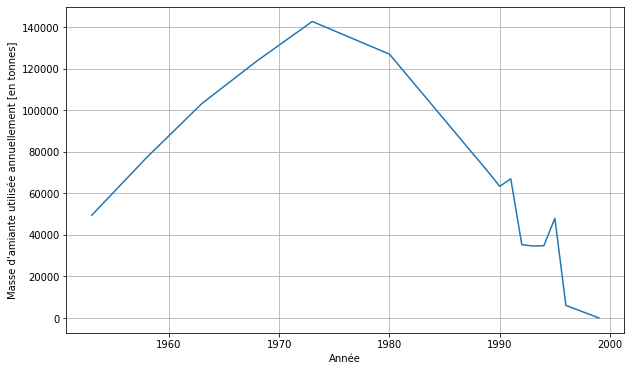

In [4]:
#partie pour l'évolution de la quantité d'amiante en France
x = np.arange(1953,1999.1,1) #initialisation de la variable
f1=scipy.interpolate.interp1d(conso_an[0],conso_an[1],kind='linear')
f2=scipy.interpolate.interp1d(conso_an[0],conso_an[1],kind='cubic')
conso_an_intp = f1(x)

#création du graphe
plt.figure(figsize=(10,6))
plt.plot(x,conso_an_intp)
plt.grid()
plt.xlabel('Année')
plt.ylabel("Masse d'amiante utilisée annuellement [en tonnes]")
plt.show()

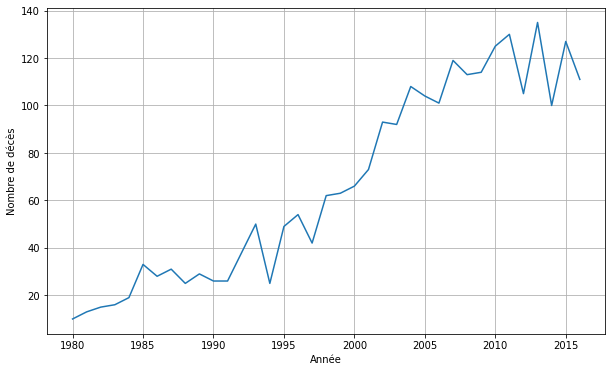

In [5]:
#pour la partie Asbestose
plt.figure(figsize=(10,6))
plt.plot(décès_asbestose['Année'],décès_asbestose['Asbestose'])
plt.xlabel("Année")
plt.ylabel("Nombre de décès")
plt.grid()
plt.show()

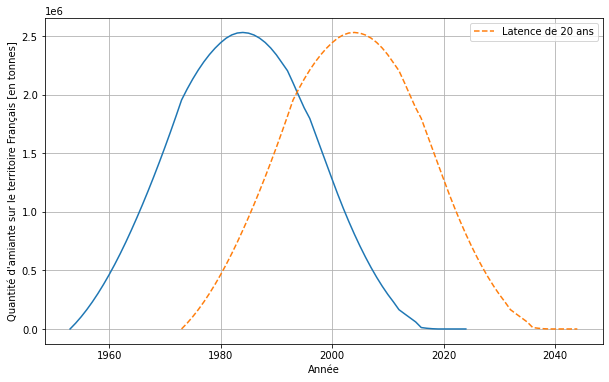

In [6]:
#création de la fonction cumul sur 20 ans qui permet de prendre la quantité d'amiante en France en considérant que ce matériaux est retiré au bout de 20 ans de vie.
Exposition = []

for i in range(2025-1953):
  if i < 20:
    Exposition.append(np.sum(conso_an_intp[0:i]))
  else:
    Exposition.append(np.sum(conso_an_intp[i-20:i]))

#création d'un graph pour représenter le cumul sur 20   
plt.figure(figsize=(10,6))
plt.plot(range(1953,2025),Exposition)
plt.plot(range(1953+20,2025+20),Exposition,"--",label="Latence de 20 ans")
plt.grid()
plt.xlabel("Année")
plt.ylabel("Quantité d'amiante sur le territoire Français [en tonnes]")
plt.legend()
plt.show()

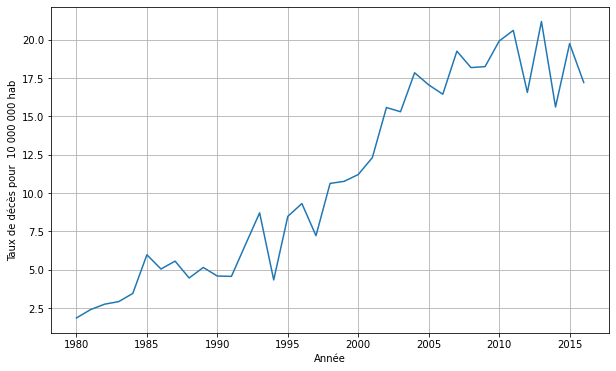

In [7]:
#création de variables permettant d'extraire les valeurs de la population 
#Française sur l'intervalle voulu
population_80_16 = population[population['Année']<2017]
population_80_16 = population_80_16[population_80_16['Année']>1979]
population_80_16 = population_80_16.reset_index(drop=True)

#création du graphe
plt.figure(figsize=(10,6))
plt.plot(décès_asbestose['Année'],[décès_asbestose['Asbestose'][i]/population_80_16['Population au 1er janvier'][i]*10000000 for i in décès_asbestose.index])
plt.xlabel("Année")
plt.ylabel("Taux de décès pour  10 000 000 hab")
plt.grid()
plt.show()

In [8]:
def regpoisson(x,param0,param1):
    return [param0 + Exposition[i] * param1 + np.log(pop[i-6-20]) for i in range(0,35)]

In [9]:
param,cov = opt.curve_fit(regpoisson,range(0,35),décès_asbestose["Asbestose"][2:],p0=[0,1])
perr = np.sqrt(np.diag(cov))

In [10]:
print("beta0 =",param[0],"+/-",perr[0])
print("beta1 =",param[1],"+/-",perr[1])

beta0 = -9.421931859863953 +/- 3.477292905372622
beta1 = 4.233883223930766e-05 +/- 2.0343674249889384e-06


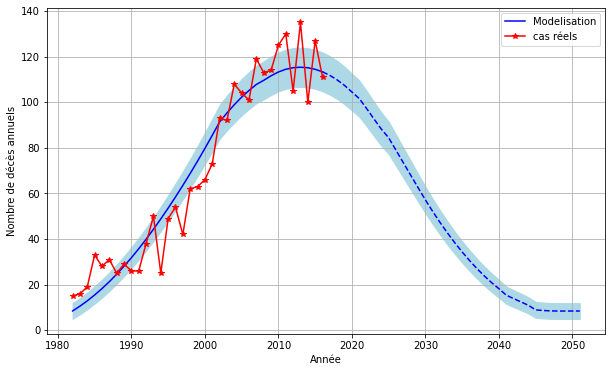

In [11]:
modelisation = [param[0] + Exposition[i] * param[1] + np.log(pop[i-6-20]) for i in range(0,70)]
modelisation_1 = [param[0]-perr[0] + Exposition[i] * (param[1]-perr[1]) + np.log(pop[i-6-20]) for i in range(0,70)] #moyenne basse
modelisation_2 = [param[0]+perr[0] + Exposition[i] * (param[1]+perr[1]) + np.log(pop[i-6-20]) for i in range(0,70)] #moyenne haute

plt.figure(figsize=(10,6))
plt.plot(décès_asbestose["Année"][2:],modelisation[0:35],"-b",label='Modelisation')
plt.fill_between(x=range(1982,2052),y1=modelisation_1[:70],y2=modelisation_2[:70],color="lightblue")
plt.plot(range(2016,2052),modelisation[34:70],"--b")
plt.plot(décès_asbestose["Année"][2:],décès_asbestose["Asbestose"][2:],'-*r',label="cas réels")
plt.xlabel("Année")
plt.ylabel("Nombre de décès annuels")
plt.grid()
plt.legend()
plt.show()

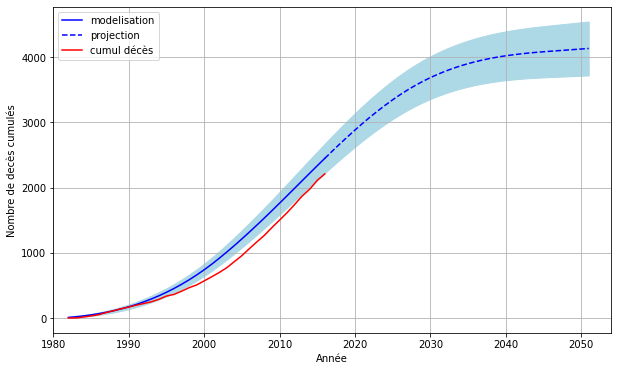

Nombre de décès cumulés attendus entre 2016 et 2050 : 1676 +/- 370


In [12]:
cumulpoisson=[np.sum(modelisation[:i]) for i in range(1,len(modelisation)+1)]
cumulpoisson_1=[np.sum(modelisation_1[:i]) for i in range(1,len(modelisation_1)+1)]
cumulpoisson_2=[np.sum(modelisation_2[:i]) for i in range(1,len(modelisation_2)+1)]

cumuldécès = [np.sum(décès_asbestose["Asbestose"][2:i]) for i in range(1,len(décès_asbestose["Asbestose"])-1)]

plt.figure(figsize=(10,6))

plt.plot(range(1982,2017),cumulpoisson[:35],"-b",label='modelisation')
plt.plot(range(2016,2052),cumulpoisson[34:70],"--b",label='projection')
plt.fill_between(x=range(1982,2052),y1=cumulpoisson_1[:70],y2=cumulpoisson_2[:70],color="lightblue")

plt.xlabel("Année")
plt.ylabel("Nombre de decès cumulés")
plt.xlim(1980,2054)
plt.plot(décès_asbestose["Année"][2:],cumuldécès,"-",label="cumul décès",c="red")
plt.legend()
plt.grid()
plt.show()

print("Nombre de décès cumulés attendus entre 2016 et 2050 :",int(cumulpoisson[68]-cumulpoisson[34]),"+/-",int(cumulpoisson_2[68]-cumulpoisson_2[34])-int(cumulpoisson_1[68]-cumulpoisson_1[34]))

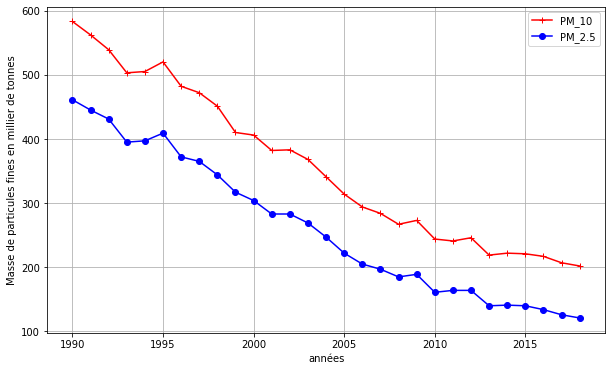

In [13]:
PM_10=[583,562,539,503,505,520,482,472,451,410,406,382,383,368,341,\
       314,294,284,267,273,244,241,246,219,222,221,217,207,202]
PM_2=[461,445,431,395,397,409,372,365,344,317,304,283,283,269,247,\
      222,205,197,185,189,161,164,164,140,141,140,134,126,121]

années_test=[]
j=0
for i in PM_10:
  années_test.append(1990+j)
  j=j+1

plt.figure(figsize=(10,6))
plt.plot(années_test,PM_10,"r+-",label='PM_10')
plt.xlabel("années")
plt.ylabel("Masse de particules fines en millier de tonnes")
plt.plot(années_test,PM_2,"bo-",label='PM_2.5')
plt.legend()
plt.grid()
plt.show()

In [14]:
#création des variables
années_T=[1953,1960,1967,1980,1986,1991,1995,2000,2003]
H_tot=[72,57,45,44,44,38,36,33,30] #taux de fumeurs hommes
H_nbjour=[11,12.6,14,15.8,17,16.1,14.7,13.8,14.0] #nombre de cigarettes par jours
F_tot=[9,11,10,16,20,20,21,21,22]#taux de fumeurs femmes
F_nbjour=[4,6,8,11.8,13,13.2,13,12.7,12] #nombre cigarettes par jours

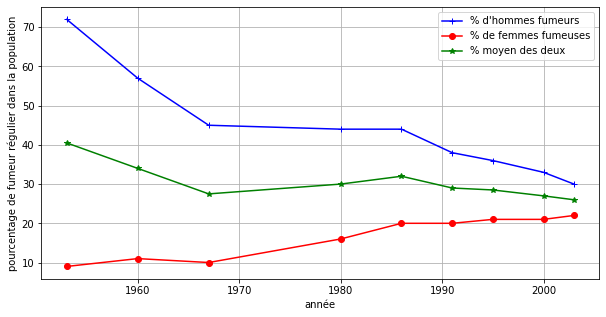

In [15]:
tot=[]
j=0
#boucle
for i in H_tot:
  tot.append((i+float(F_tot[j]))/2) #réalise une moyenne entre les hommes et les femmes
  j=j+1

#Création du graphe
plt.figure(figsize=(10,5))
plt.plot(années_T,H_tot,'b+-',label="% d'hommes fumeurs")
plt.plot(années_T,F_tot,"ro-",label="% de femmes fumeuses")
plt.plot(années_T,tot,'g*-',label="% moyen des deux")
plt.xlabel("année")
plt.ylabel("pourcentage de fumeur régulier dans la population")
plt.grid()
plt.legend()
plt.show()

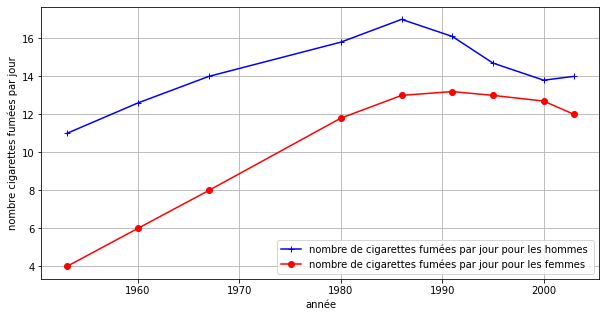

In [16]:
#création du graphe
plt.figure(figsize=(10,5))
plt.plot(années_T,H_nbjour,"b+-",label="nombre de cigarettes fumées par jour pour les hommes ")
plt.xlabel("année")
plt.ylabel("nombre cigarettes fumées par jour")
plt.plot(années_T,F_nbjour,"ro-",label="nombre de cigarettes fumées par jour pour les femmes ")
plt.grid()
plt.legend()
plt.show()